### 30 day Feature Selection. 
UPDATE: June 4th. Changing this to the single solvers and updated temps from my reduction code. 

In [1]:
# relevant import statements
import math
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sns  # statistical data visualization
import xarray as xr
##just to stop the excess number of warnings
import warnings
# plotting related imports
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

In [2]:
# load input solvers
infile = open("../../reduced_data/PCs/U_30.p","rb",)
U_PC = pickle.load(infile)  
infile.close()

infile = open("../../reduced_data/PCs/EHF_30.p","rb",)
EHF_PC = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

infile = open("../../reduced_data/PCs/GPH_30.p","rb",)
GPH_PC = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

print("PCs loaded ...")

PCs loaded ...


In [3]:
##############################################################
#Below is PCs combined for U GPH, and EHF with 14-day lagged temperatures. 1959/1960 to 2020/2021. 
print("###############################")
print("Begin FS Model ...")

###############################
Begin FS Model ...


## CHANGE OUTPUT IN THE CELL BELOW. 

In [4]:
# load output data
infile = open("../../reduced_data/temps/seus_30.p","rb",)
temp = pickle.load(infile) 
infile.close()

In [5]:
##for 14 days leadtime, the temp starts at day 33, which is different from how it will be represented
#in the actual LSTM model
print("Output shape: ",temp.shape)

Output shape:  (8246,)


In [6]:
##specify lag based on the leadtime
#149 for 14
#143 for 20
#133 for 30

lag = 133
region = "SE US"
reg = "seus"

In [7]:
###############################################################
inputvar = np.concatenate((U_PC[:,1:],EHF_PC[:,1:],GPH_PC[:,1:]),axis=1) #first 10 is U, second 45 is EHF, last 10 is GPH
##should be 62 columns. 
##make pandas dataframe for RF
input = pd.DataFrame(inputvar)
print("Input Dataframe")
print(input)

Input Dataframe
            0         1         2         3         4         5         6   \
0     0.791039 -1.727149  1.481165 -1.684007  0.329935  1.656387 -0.211460   
1     0.821552 -1.842438  1.416795 -1.725300 -0.155038  2.059544  0.081825   
2     0.888491 -1.958864  1.626327 -1.405833 -0.030527  1.728328  0.536282   
3     0.883083 -1.953125  1.878820 -0.966085  0.620002  1.275088  0.679312   
4     0.799762 -1.914598  1.794036 -0.578514  1.147515  0.969589  0.594968   
...        ...       ...       ...       ...       ...       ...       ...   
8241  0.365138 -0.264957 -0.490060 -0.512342  1.103917 -0.207999 -0.193766   
8242  0.377834 -0.232725 -0.501459 -0.683322  1.191196 -0.189878 -0.079677   
8243  0.407191 -0.267839 -0.540451 -0.462611  1.100748 -0.241352 -0.035284   
8244  0.479949 -0.340080 -0.574400 -0.028467  0.869308 -0.287936  0.115129   
8245  0.561745 -0.258596 -0.428451  0.401685  0.934890 -0.598157 -0.450557   

            7         8         9   ...        

In [8]:
##Set X_all and Y_all datasets
X_all = np.copy(input)
Y_all = np.copy(temp)

##training data partition out
X_train = X_all[: 57 * lag, :]
Y_train = Y_all[: 57 * lag]

# testing data partition out
X_test = X_all[57 * lag :, :]
Y_test = Y_all[57 * lag :]

##set fraction of data as 5 years
frac_ind = lag * 5

In [9]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
# the model to throw back no loss
if np.any(np.isnan(X_all)) or np.any(np.isinf(X_all)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

In [10]:
##############################################################
# ## Begin setting up parts of my model architecture.
# This will be the random forest intermission.
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import cross_val_score

In [11]:
#save PREDICTIONS
##accuracy scores, just cause. No use otherwise beyond checking for overfit. 
acc_reg1_val = []
acc_reg1_train = []
acc_reg1_test = []

pred_val1 = []
pred_train1 = []
pred_test1 = []

important = np.empty((100,62)) #cross validation # and # of PCs

In [12]:
#create initial regressor for rf to do feature selection 
print("Initalizing RF Model")
rf_reg1 = RandomForestClassifier(max_depth=3, n_estimators=750, random_state=42)

Initalizing RF Model


In [13]:
print("Starting Cross Validation ...")
##make loop for cross validation 
for l in range(0,100):
    print("Cross Val #:"+str(l))
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_train[:,0])-frac_ind)
    end = start+(frac_ind)

    X_val = X_train[start:end,:]
    Y_val = Y_train[start:end]
    
    X_train1 = X_train[0:start]
    Y_train1 = Y_train[0:start]
    X_train2 = X_train[end:]
    Y_train2 = Y_train[end:]

    ##concatenate all of these
    X_tr = np.concatenate([X_train1,X_train2], axis = 0)
    Y_tr = np.concatenate((Y_train1,Y_train2))

    #train rf
    rf_reg1.fit(X_tr, Y_tr)

    #prediction with validation data
    pred_val = rf_reg1.predict(X_val)
    pred_val1.append(rf_reg1.predict_proba(X_val))
    acc_reg1_val.append(accuracy_score(Y_val, pred_val))
    
    #prediction with training data
    pred_train = rf_reg1.predict(X_tr)
    pred_train1.append(rf_reg1.predict_proba(X_tr))
    acc_reg1_train.append(accuracy_score(Y_tr, pred_train))

    #prediction with testing data
    pred_test = rf_reg1.predict(X_test)
    pred_test1.append(rf_reg1.predict_proba(X_test))
    acc_reg1_test.append(accuracy_score(Y_test, pred_test))

    #prepare to show relevant features by actually ... choosing them 
    selector = SelectFromModel(rf_reg1, threshold="mean", max_features=None)
    X_train_selected = selector.transform(X_tr)
    X_test_selected = selector.transform(X_test)

    #print names of selected features
    selected_features = input.columns[selector.get_support()]
    print(f'Selected Features: {selected_features}')

    importances = rf_reg1.feature_importances_
    important[l,:] = importances[:]

Starting Cross Validation ...
Cross Val #:0
Selected Features: Int64Index([0, 1, 3, 4, 9, 13, 25, 49, 53, 56, 59], dtype='int64')
Cross Val #:1
Selected Features: Int64Index([0, 1, 3, 4, 9, 13, 19, 49, 53, 54, 56], dtype='int64')
Cross Val #:2
Selected Features: Int64Index([0, 1, 3, 9, 10, 11, 13, 14, 18, 49, 53, 54, 56], dtype='int64')
Cross Val #:3
Selected Features: Int64Index([0, 1, 3, 9, 13, 17, 25, 49, 53, 54, 56], dtype='int64')
Cross Val #:4
Selected Features: Int64Index([0, 1, 3, 9, 13, 14, 18, 25, 53, 54, 56], dtype='int64')
Cross Val #:5
Selected Features: Int64Index([0, 1, 3, 4, 9, 13, 17, 25, 49, 53, 56, 59], dtype='int64')
Cross Val #:6
Selected Features: Int64Index([0, 1, 3, 4, 7, 9, 13, 17, 18, 25, 49, 53, 54, 56, 57], dtype='int64')
Cross Val #:7
Selected Features: Int64Index([0, 1, 3, 4, 9, 13, 25, 49, 53, 56, 59], dtype='int64')
Cross Val #:8
Selected Features: Int64Index([0, 1, 3, 4, 5, 7, 9, 10, 13, 17, 25, 49, 53, 56], dtype='int64')
Cross Val #:9
Selected Feature

In [14]:
print('###################################################')
print("Model CV Completed.")

###################################################
Model CV Completed.


In [15]:
print(f'Accuracy, Validation: {np.mean(acc_reg1_val) * 100:.2f}%')
print(f'Accuracy, Training: {np.mean(acc_reg1_train) * 100:.2f}%')
print(f'Accuracy, Testing: {np.mean(acc_reg1_test) * 100:.2f}%')

Accuracy, Validation: 63.90%
Accuracy, Training: 64.13%
Accuracy, Testing: 61.35%


In [16]:
pred_train1 = np.array(pred_train1)
pred_test1 = np.array(pred_test1)
pred_val1 = np.array(pred_val1)

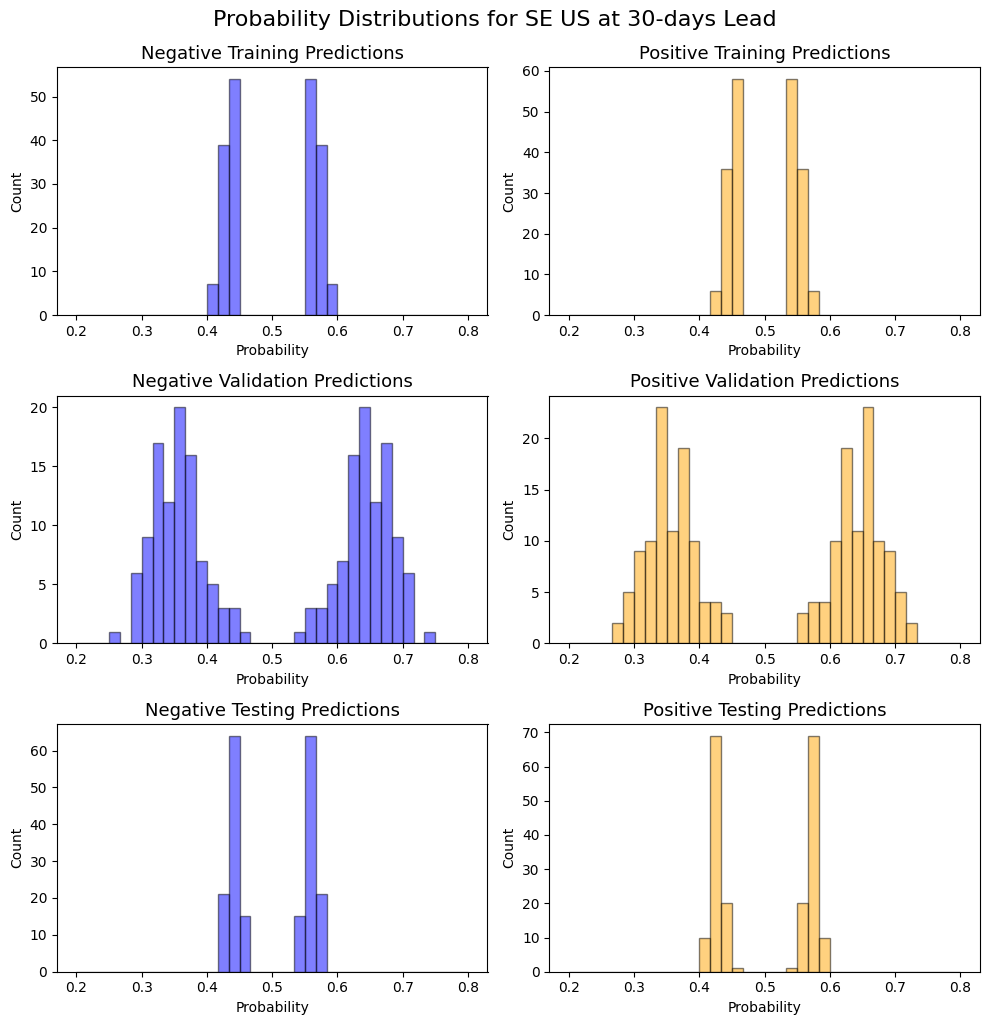

In [17]:
bins = np.linspace(0.2, 0.8, 37)  #10 bins from 0.4 to 1
##bin the probabilities
counts_neg_test, edges_neg_test = np.histogram(pred_test1[:,0], bins=bins)
counts_pos_test, edges_pos_test = np.histogram(pred_test1[:,1], bins=bins)

counts_neg_train, edges_neg_train = np.histogram(pred_train1[:,0], bins=bins)
counts_pos_train, edges_pos_train = np.histogram(pred_train1[:,1], bins=bins)

counts_neg_val, edges_neg_val = np.histogram(pred_val1[:,0], bins=bins)
counts_pos_val, edges_pos_val = np.histogram(pred_val1[:,1], bins=bins)

fig, axes = plt.subplots(3, 2, figsize=(10,10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

ax1.bar(edges_neg_train[:-1], counts_neg_train, width=np.diff(edges_neg_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_title('Negative Training Predictions', fontsize=13)
ax1.set_xlabel('Probability')
ax1.set_ylabel('Count')

ax2.bar(edges_pos_train[:-1], counts_pos_train, width=np.diff(edges_pos_train), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax2.set_title('Positive Training Predictions', fontsize=13)
ax2.set_xlabel('Probability')
ax2.set_ylabel('Count')

ax3.bar(edges_neg_val[:-1], counts_neg_val, width=np.diff(edges_neg_val), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax3.set_title('Negative Validation Predictions', fontsize=13)
ax3.set_xlabel('Probability')
ax3.set_ylabel('Count')

ax4.bar(edges_pos_val[:-1], counts_pos_val, width=np.diff(edges_pos_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax4.set_title('Positive Validation Predictions', fontsize=13)
ax4.set_xlabel('Probability')
ax4.set_ylabel('Count')

ax5.bar(edges_neg_test[:-1], counts_neg_test, width=np.diff(edges_neg_test), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax5.set_title('Negative Testing Predictions', fontsize=13)
ax5.set_xlabel('Probability')
ax5.set_ylabel('Count')

ax6.bar(edges_pos_test[:-1], counts_pos_test, width=np.diff(edges_pos_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax6.set_title('Positive Testing Predictions', fontsize=13)
ax6.set_xlabel('Probability')
ax6.set_ylabel('Count')

plt.tight_layout()
fig.suptitle("Probability Distributions for "+region+" at 30-days Lead",y=1.02,fontsize=16)
plt.savefig("../images/probability_distrib_"+reg+"30.png")

In [18]:
imp = np.nanmean(important, axis = 0)
imp.shape

(62,)

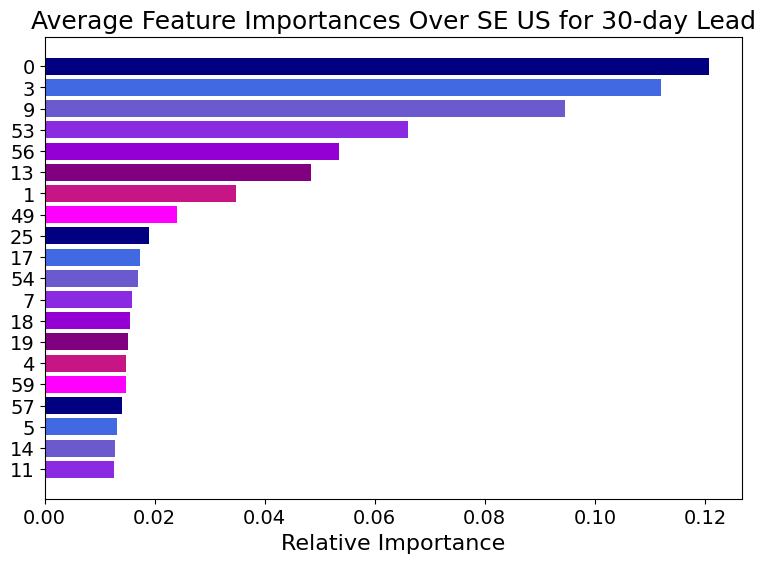

In [19]:
#plot features by relative importance
indices = np.argsort(imp)[::-1]  #sort by importance
c = ["navy","royalblue","slateblue","blueviolet","darkviolet","purple","mediumvioletred","magenta"]

plt.figure(figsize=(9, 6))
plt.title("Average Feature Importances Over "+region+" for 30-day Lead",fontsize =18)
plt.barh(range(0,20), imp[indices[:20]], align="center", color = c)
plt.yticks(range(0,20), input.columns[indices[:20]],fontsize =14)
plt.xticks(fontsize =14)
plt.xlabel("Relative Importance",fontsize =16)
plt.gca().invert_yaxis()
plt.savefig("../images/30day_"+reg+".png")

In [20]:
input.columns[indices[:20]]

Int64Index([0, 3, 9, 53, 56, 13, 1, 49, 25, 17, 54, 7, 18, 19, 4, 59, 57, 5,
            14, 11],
           dtype='int64')

In [21]:
##for the updated times and 100 CVs

#EUROPE
#IInt64Index([1, 56, 18, 2, 54, 53, 19, 49, 24, 48, 12, 8, 0, 25, 55, 17, 38, 60, 23, 5],dtype='int64')
#Accuracy, Validation: 64.38%
#Accuracy, Training: 65.52%
#Accuracy, Testing: 65.71%

##CANADA
#Int64Index([56, 1, 0, 55, 2, 57, 4, 54, 22, 6, 53, 26, 25, 30, 9, 18, 13, 17, 3, 38],dtype='int64')
#Accuracy, Validation: 76.72%
#Accuracy, Training: 77.42%
#Accuracy, Testing: 77.12%

##SE US
#Int64Index([0, 3, 9, 53, 56, 13, 1, 49, 25, 17, 54, 7, 18, 19, 4, 59, 57, 5,14, 11],dtype='int64')
#Accuracy, Validation: 63.90%
#Accuracy, Training: 64.13%
#Accuracy, Testing: 61.35%

In [22]:
#on 100 CVs
'''
##Europe
Index([1, 56, 0, 54, 9, 57, 55, 3, 26, 4], dtype='int64')
Accuracy, Validation: 70.32%
Accuracy, Training: 71.62%
Accuracy, Testing: 70.81%

##Nova
Index([1, 56, 0, 55, 2, 53, 54, 9, 4, 22], dtype='int64')
Accuracy, Validation: 80.75%
Accuracy, Training: 82.18%
Accuracy, Testing: 82.67%

##South
Index([1, 56, 54, 53, 55, 4, 3, 21, 14, 0], dtype='int64')
Accuracy, Validation: 68.74%
Accuracy, Training: 70.58%
Accuracy, Testing: 67.67%
'''

"\n##Europe\nIndex([1, 56, 0, 54, 9, 57, 55, 3, 26, 4], dtype='int64')\nAccuracy, Validation: 70.32%\nAccuracy, Training: 71.62%\nAccuracy, Testing: 70.81%\n\n##Nova\nIndex([1, 56, 0, 55, 2, 53, 54, 9, 4, 22], dtype='int64')\nAccuracy, Validation: 80.75%\nAccuracy, Training: 82.18%\nAccuracy, Testing: 82.67%\n\n##South\nIndex([1, 56, 54, 53, 55, 4, 3, 21, 14, 0], dtype='int64')\nAccuracy, Validation: 68.74%\nAccuracy, Training: 70.58%\nAccuracy, Testing: 67.67%\n"

In [23]:
#Remember that for these ...
# [0-8] is U wind
# [9-52] is EHF
# [53-62] is GPH